# Installing requirements

In [25]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from huggingface_hub import notebook_login
import datasets
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.0 MB 9.3 MB/s eta 0:00:01
   ---------------- ----------------------- 3.4/8.0 MB 9.1 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.0 MB 9.5 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.0 MB 8.9 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.0 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 7.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------------------------------- ------- 2.1/2.6 MB 9.8 MB/s eta 

# Download the dataset

In [10]:
notebook_login()
hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
dataset = hugging_face_dataset['train'].to_pandas()

In [11]:
dataset[dataset['turn'] > 3][:1]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


# Create text-author pairs

In [12]:
# Initialize an empty list for processed data
text_author_pairs = []

# Iterate through each row of the DataFrame
for _, row in dataset.iterrows():
    # Process conversation_a (assistant role)
    for message in row["conversation_a"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_a"]
            })

    # Process conversation_b (assistant role)
    for message in row["conversation_b"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_b"]
            })

    # Process user messages (common across both conversations)
    # for message in row["conversation_a"]:  # Check only `conversation_a` since user messages are identical
    #     if message["role"] == "user":
    #         text_author_pairs.append({
    #             "text": message["content"],
    #             "author": "human"
    #         })

# Create token count vectors for each text

In [13]:
# Extract paragraphs and their authors
paragraphs = [entry["text"] for entry in text_author_pairs]
authors = [entry["author"] for entry in text_author_pairs]

# Vectorize the paragraphs
vectorizer = CountVectorizer()
text_vectors = vectorizer.fit_transform(paragraphs)  # Each row is a paragraph

# Group texts by author

In [14]:
# Sum all token instances by author.
author_vectors = {}
author_count = {} # Also count how many texts are attributed to each author
for i, author in enumerate(tqdm(authors)):
    if author == 'human' :
        continue
    if author not in author_vectors:
        # Add this new author to the list.
        author_vectors[author] = text_vectors[i].toarray()
        author_count[author] = 1
    else:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        author_vectors[author] += text_vectors[i].toarray()
        author_count[author] += 1

# Convert to a more readable format (if needed)
author_df = pd.DataFrame({author: vector.flatten() for author, vector in author_vectors.items()},
                         index=vectorizer.get_feature_names_out())

author_df

100%|██████████████████████████████████████████████████████████████████████████| 78632/78632 [00:50<00:00, 1557.75it/s]


,chatglm-6b,koala-13b,oasst-pythia-12b,alpaca-13b,vicuna-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,llama-13b,fastchat-t5-3b,gpt-3.5-turbo,gpt-4,RWKV-4-Raven-14B,claude-v1,mpt-7b-chat,palm-2,claude-instant-v1,vicuna-7b,wizardlm-13b,gpt4all-13b-snoozy,guanaco-33b
00,136,64,238,47,155,18,52,23,37,39,78,27,57,32,87,18,83,6,28,3
000,114,204,129,37,227,100,54,69,86,149,216,80,464,94,252,227,60,40,45,20
0000,2,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,8,3,11,1
00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
000000,1,2,0,0,1,2,1,0,0,1,0,0,0,0,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
힘을,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
３丁目のトメさんがくれたチキン味のカリカリについて,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
５点満点で採点してにゃ,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [15]:
# Find the average text length of each author. 
author_length = {author: np.sum(vector) / author_count[author] for author, vector in author_vectors.items()}

# Normalise the length of each corpus.
for author in author_count :
    author_df[author] /= np.sum(author_df[author])
    
# Since it has been lost, add the average text length as a separate feature.
author_df = pd.concat([author_df, pd.DataFrame(author_length, index = ['_length'])])

author_df

,chatglm-6b,koala-13b,oasst-pythia-12b,alpaca-13b,vicuna-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,llama-13b,fastchat-t5-3b,gpt-3.5-turbo,gpt-4,RWKV-4-Raven-14B,claude-v1,mpt-7b-chat,palm-2,claude-instant-v1,vicuna-7b,wizardlm-13b,gpt4all-13b-snoozy,guanaco-33b
00,0.000271,0.000073,0.000416,0.000186,0.000175,0.000093,0.000136,0.000175,0.000092,0.000071,0.000116,0.000057,0.000080,0.000110,0.000172,0.000041,0.000187,0.000036,0.000227,0.000017
000,0.000227,0.000234,0.000225,0.000147,0.000256,0.000519,0.000141,0.000524,0.000214,0.000271,0.000321,0.000169,0.000653,0.000324,0.000498,0.000519,0.000135,0.000243,0.000365,0.000112
0000,0.000004,0.000000,0.000000,0.000000,0.000001,0.000005,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000018,0.000018,0.000089,0.000006
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000
000000,0.000002,0.000002,0.000000,0.000000,0.000001,0.000010,0.000003,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000004,0.000002,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
３丁目のトメさんがくれたチキン味のカリカリについて,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
５点満点で採点してにゃ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
author_df.loc['00']

chatglm-6b                 0.000271
koala-13b                  0.000073
oasst-pythia-12b           0.000416
alpaca-13b                 0.000186
vicuna-13b                 0.000175
dolly-v2-12b               0.000093
stablelm-tuned-alpha-7b    0.000136
llama-13b                  0.000175
fastchat-t5-3b             0.000092
gpt-3.5-turbo              0.000071
gpt-4                      0.000116
RWKV-4-Raven-14B           0.000057
claude-v1                  0.000080
mpt-7b-chat                0.000110
palm-2                     0.000172
claude-instant-v1          0.000041
vicuna-7b                  0.000187
wizardlm-13b               0.000036
gpt4all-13b-snoozy         0.000227
guanaco-33b                0.000017
Name: 00, dtype: float64

In [17]:
common_tokens_only = author_df[author_df.ne(0).sum(axis=1) == 20]

common_tokens_only

,chatglm-6b,koala-13b,oasst-pythia-12b,alpaca-13b,vicuna-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,llama-13b,fastchat-t5-3b,gpt-3.5-turbo,gpt-4,RWKV-4-Raven-14B,claude-v1,mpt-7b-chat,palm-2,claude-instant-v1,vicuna-7b,wizardlm-13b,gpt4all-13b-snoozy,guanaco-33b
00,0.000271,0.000073,0.000416,0.000186,0.000175,0.000093,0.000136,0.000175,0.000092,0.000071,0.000116,0.000057,0.000080,0.000110,0.000172,0.000041,0.000187,0.000036,0.000227,0.000017
000,0.000227,0.000234,0.000225,0.000147,0.000256,0.000519,0.000141,0.000524,0.000214,0.000271,0.000321,0.000169,0.000653,0.000324,0.000498,0.000519,0.000135,0.000243,0.000365,0.000112
01,0.000030,0.000019,0.000073,0.000028,0.000068,0.000291,0.000003,0.000023,0.000022,0.000026,0.000034,0.000114,0.000041,0.000066,0.000036,0.000039,0.000084,0.000043,0.000146,0.000006
03,0.000006,0.000009,0.000035,0.000004,0.000018,0.000047,0.000003,0.000099,0.000022,0.000009,0.000010,0.000013,0.000001,0.000010,0.000020,0.000011,0.000009,0.000030,0.000032,0.000017
05,0.000028,0.000005,0.000077,0.000099,0.000026,0.000119,0.000008,0.000023,0.000010,0.000031,0.000037,0.000023,0.000046,0.000014,0.000024,0.000023,0.000007,0.000043,0.000016,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zero,0.000064,0.000073,0.000044,0.000048,0.000066,0.000099,0.000016,0.000046,0.000097,0.000097,0.000105,0.000068,0.000084,0.000083,0.000063,0.000073,0.000068,0.000213,0.000049,0.000078
zone,0.000004,0.000028,0.000019,0.000036,0.000026,0.000067,0.000016,0.000038,0.000025,0.000128,0.000028,0.000025,0.000044,0.000024,0.000038,0.000034,0.000016,0.000049,0.000008,0.000011
zu,0.000173,0.000085,0.000372,0.000286,0.000254,0.000171,0.000138,0.000046,0.000340,0.000512,0.000490,0.000306,0.000300,0.000345,0.000002,0.000284,0.000241,0.000274,0.000041,0.000431
на,0.000050,0.000002,0.000040,0.000067,0.000087,0.000057,0.000052,0.000023,0.000094,0.000120,0.000140,0.000065,0.000117,0.000138,0.000002,0.000089,0.000111,0.000122,0.000008,0.000123


# Centering

In [18]:
features_mean = {feature: np.mean(common_tokens_only.loc[feature]) for feature in common_tokens_only.index}
for feature in common_tokens_only.index :
    common_tokens_only.loc[feature] -= features_mean[feature]

common_tokens_only

,chatglm-6b,koala-13b,oasst-pythia-12b,alpaca-13b,vicuna-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,llama-13b,fastchat-t5-3b,gpt-3.5-turbo,gpt-4,RWKV-4-Raven-14B,claude-v1,mpt-7b-chat,palm-2,claude-instant-v1,vicuna-7b,wizardlm-13b,gpt4all-13b-snoozy,guanaco-33b
00,0.000135,-0.000063,0.000279,0.000050,3.788724e-05,-0.000043,-7.573355e-07,0.000038,-0.000045,-0.000066,-0.000021,-0.000080,-0.000056,-0.000026,3.519423e-05,-0.000095,0.000051,-0.000100,0.000090,-0.000120
000,-0.000078,-0.000071,-0.000080,-0.000158,-4.931819e-05,0.000214,-1.637968e-04,0.000219,-0.000091,-0.000033,0.000016,-0.000136,0.000348,0.000019,1.927756e-04,0.000215,-0.000169,-0.000062,0.000060,-0.000193
01,-0.000030,-0.000040,0.000014,-0.000032,8.116125e-06,0.000231,-5.682068e-05,-0.000037,-0.000037,-0.000034,-0.000025,0.000055,-0.000019,0.000006,-2.388649e-05,-0.000021,0.000024,-0.000017,0.000087,-0.000054
03,-0.000014,-0.000011,0.000015,-0.000016,-2.299262e-06,0.000026,-1.769979e-05,0.000078,0.000002,-0.000011,-0.000010,-0.000008,-0.000019,-0.000010,-5.642026e-07,-0.000009,-0.000011,0.000010,0.000012,-0.000004
05,-0.000005,-0.000029,0.000044,0.000066,-7.290701e-06,0.000086,-2.534669e-05,-0.000010,-0.000023,-0.000002,0.000004,-0.000010,0.000013,-0.000019,-9.486762e-06,-0.000010,-0.000026,0.000009,-0.000017,-0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zero,-0.000013,-0.000003,-0.000033,-0.000029,-1.019177e-05,0.000022,-6.093946e-05,-0.000031,0.000020,0.000020,0.000029,-0.000009,0.000008,0.000006,-1.342101e-05,-0.000003,-0.000009,0.000136,-0.000028,0.000002
zone,-0.000029,-0.000006,-0.000014,0.000003,-7.241709e-06,0.000034,-1.745972e-05,0.000005,-0.000008,0.000094,-0.000005,-0.000008,0.000010,-0.000009,4.386004e-06,0.000001,-0.000017,0.000015,-0.000025,-0.000022
zu,-0.000081,-0.000170,0.000118,0.000031,-1.312166e-07,-0.000083,-1.160967e-04,-0.000209,0.000086,0.000257,0.000235,0.000052,0.000045,0.000090,-2.525927e-04,0.000029,-0.000013,0.000019,-0.000214,0.000177
на,-0.000026,-0.000073,-0.000035,-0.000008,1.130474e-05,-0.000018,-2.313058e-05,-0.000053,0.000019,0.000045,0.000064,-0.000010,0.000041,0.000063,-7.340892e-05,0.000014,0.000035,0.000046,-0.000067,0.000048


# Standardisation

In [19]:
features_std = {feature: np.std(common_tokens_only.loc[feature]) for feature in common_tokens_only.index}
for feature in common_tokens_only.index :
    common_tokens_only.loc[feature] /= features_std[feature]

common_tokens_only

,chatglm-6b,koala-13b,oasst-pythia-12b,alpaca-13b,vicuna-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,llama-13b,fastchat-t5-3b,gpt-3.5-turbo,gpt-4,RWKV-4-Raven-14B,claude-v1,mpt-7b-chat,palm-2,claude-instant-v1,vicuna-7b,wizardlm-13b,gpt4all-13b-snoozy,guanaco-33b
00,1.461036,-0.686436,3.030776,0.541540,0.411307,-0.468760,-0.008222,0.413005,-0.485615,-0.711873,-0.225943,-0.863868,-0.612133,-0.285152,0.382071,-1.035934,0.550429,-1.087201,0.981721,-1.300749
000,-0.504904,-0.462019,-0.517668,-1.029055,-0.321084,1.394599,-1.066391,1.426423,-0.594491,-0.217865,0.102896,-0.884575,2.267036,0.125456,1.255056,1.397059,-1.103325,-0.402051,0.390725,-1.255822
01,-0.465162,-0.629323,0.219676,-0.498803,0.127882,3.643806,-0.895297,-0.577504,-0.584304,-0.534637,-0.398425,0.861073,-0.293306,0.095900,-0.376368,-0.323489,0.379257,-0.266070,1.363332,-0.848237
03,-0.668707,-0.519809,0.682613,-0.762700,-0.107294,1.232200,-0.825949,3.658856,0.095082,-0.522851,-0.462905,-0.356361,-0.882185,-0.465114,-0.026328,-0.413933,-0.526611,0.470295,0.565698,-0.163997
05,-0.172768,-0.938030,1.432876,2.165385,-0.239138,2.827592,-0.831382,-0.341224,-0.762653,-0.072741,0.128960,-0.326225,0.435062,-0.636034,-0.311170,-0.337865,-0.866395,0.307088,-0.556528,-0.904810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zero,-0.337611,-0.085178,-0.868530,-0.764616,-0.268730,0.580386,-1.606809,-0.818761,0.533535,0.525465,0.759245,-0.237604,0.206629,0.162063,-0.353876,-0.089293,-0.234937,3.589104,-0.737301,0.046817
zone,-1.119312,-0.215675,-0.534488,0.098958,-0.278094,1.318943,-0.670483,0.185623,-0.318822,3.624173,-0.189215,-0.298924,0.403135,-0.345493,0.168430,0.045712,-0.665800,0.594821,-0.961074,-0.842416
zu,-0.574589,-1.202717,0.833033,0.220629,-0.000930,-0.590090,-0.822735,-1.481137,0.606968,1.823379,1.667968,0.366830,0.320578,0.639733,-1.790033,0.206890,-0.092732,0.134283,-1.516707,1.251378
на,-0.577862,-1.654298,-0.796748,-0.179408,0.255867,-0.413830,-0.523528,-1.190573,0.429654,1.014911,1.452479,-0.223897,0.937969,1.415787,-1.661506,0.313791,0.796736,1.045197,-1.522672,1.081931


In [20]:
# author_df.to_csv('bruh.csv')

C:\Users\rickc\AppData\Local\Temp\ipykernel_5176\3607572353.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  feature_graph_figure.show()


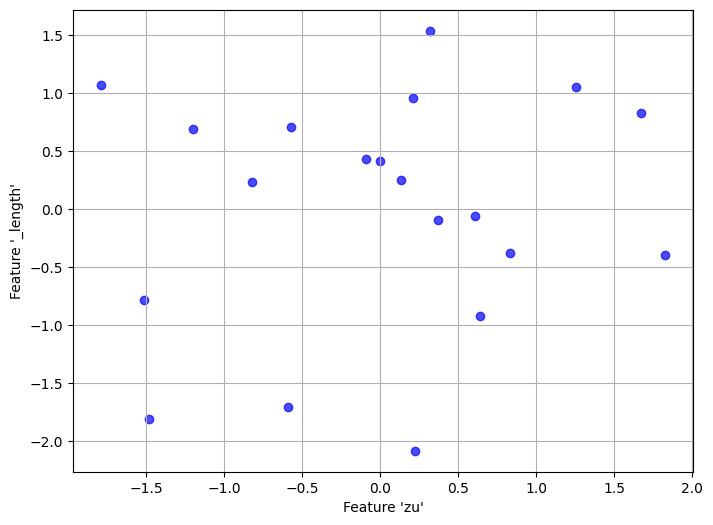

In [37]:
# Extracting the two features
x_token = 'zu'
y_token = '_length'

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(common_tokens_only.loc[x_token], common_tokens_only.loc[y_token], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [128]:
def power_iteration(A, num_iter=1000, tol=1e-6):
    """
    Power Iteration to compute the largest eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        eigenvector (np.ndarray): Approximation of the largest eigenvector.
        eigenvalue (float): Corresponding eigenvalue.
    """
    b = np.random.rand(A.shape[1])  # Random initial vector
    b = b / np.linalg.norm(b)

    error_meter = tqdm(position = 0, leave = False, total=6, bar_format='{bar} | {postfix}')
    for i in range(num_iter):
        b_next = A @ b  # Matrix-vector multiplication
        b_next = b_next / np.linalg.norm(b_next)  # Normalize
        
        # Check for convergence
        error = np.linalg.norm(b_next - b)
        error_meter.update(-np.log10(error) - error_meter.n)
        error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            error_meter.close()
            break
        b = b_next

    eigenvalue = b.T @ A @ b  # Rayleigh quotient for eigenvalue
    return b, eigenvalue

In [139]:
def pca_power_iteration(data, num_components=2, num_iter=1000):
    """
    PCA using Power Iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.

    Returns:
        components (list): List of principal components (eigenvectors).
        explained_variance (list): List of corresponding eigenvalues.
    """
    # Step 1: Center the data
    covariance_matrix = np.cov(data, rowvar=True)

    components = []
    explained_variance = []

    for i in range(num_components):
        # Step 2: Compute the largest eigenvector using power iteration
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter=num_iter)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Step 3: Deflate the covariance matrix
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        
    return components, explained_variance

In [140]:
components, explained_variance = pca_power_iteration(common_tokens_only, num_components=10)

In [142]:
print(len(components[0]))
print(components[0][:10])

3909
[ 0.00115087 -0.0274687  -0.01103057 -0.02778739 -0.01778647 -0.03164505
 -0.02934143  0.00310763 -0.02533237 -0.02481071]


C:\Users\rickc\AppData\Local\Temp\ipykernel_5176\3013497595.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  feature_graph_figure.show()


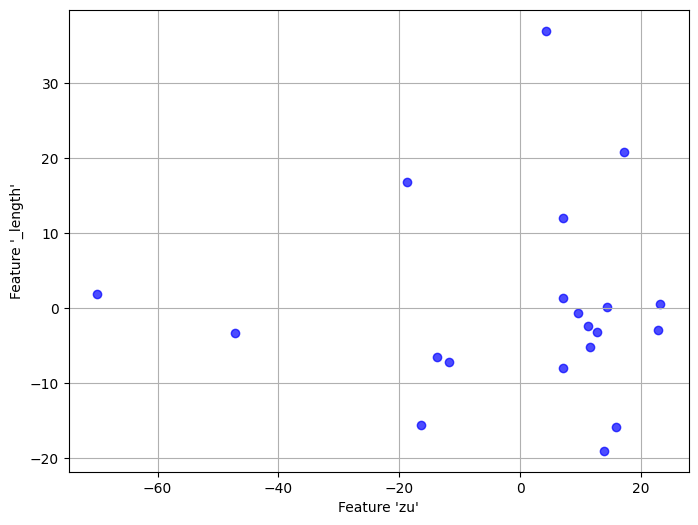

In [145]:
# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter([np.dot(common_tokens_only[author], components[0]) for author in common_tokens_only], [np.dot(common_tokens_only[author], components[9]) for author in common_tokens_only], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [26]:
!pip freeze

aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.2
anyio==4.1.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.1
beautifulsoup4==4.12.2
bleach==6.1.0
certifi==2023.11.17
cffi==1.16.0
charset-normalizer==3.3.2
colorama==0.4.6
comm==0.2.0
contourpy==1.3.1
cycler==0.12.1
datasets==3.2.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
distlib==0.3.8
executing==2.0.1
fastjsonschema==2.19.0
filelock==3.15.4
fonttools==4.55.3
fqdn==1.5.1
frozenlist==1.5.0
fsspec==2024.9.0
h11==0.14.0
huggingface-hub==0.26.5
idna==3.4
ipykernel==6.27.0
ipython==8.17.2
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.2
joblib==1.4.2
json5==0.9.14
jsonpointer==2.4
jsonschema==4.20.0
jsonschema-specifications==2023.11.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.9.0
jupyter-lsp==2.2.0
jupyter_client==8.6.0
jupyter_core==5.5.0
jupyter_server==2.10.1
jupyter_server_terminals==0.4.4
jupyterlab=